# Mixtures and MCMC

##### Keywords: supervised learning, semi-supervised learning, unsupervised learning, mixture model, gaussian mixture model, pymc3, label-switching, identifiability, normal distribution, pymc3 potentials

We now do a study of learning mixture models with MCMC. We have already done this in the case of the Zero-Inflated Poisson Model, and will stick to Gaussian Mixture models for now.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

//anaconda/envs/py3l/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Mixture of 2 Gaussians, the old faithful data

We start by considering waiting times from the Old-Faithful Geyser at Yellowstone National Park.

In [3]:
ofdata=pd.read_csv("data/oldfaithful.csv")
ofdata.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


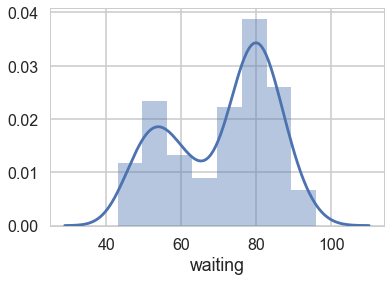

In [4]:
sns.distplot(ofdata.waiting);

Visually, there seem to be two components to the waiting time, so let us model this using a mixture of two gaussians. Remember that this is a unsupervized model, and all we are doing is modelling $p(x)$ , with the assumption that there are two clusters and a hidden variable $z$ that indexes them.

Notice that these gaussians seem well separated. The separation of gaussians impacts how your sampler will perform.

In [5]:
with pm.Model() as ofmodel:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=ofdata.shape[0])
    sds = pm.Uniform("sds", 0, 40, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([50, 80]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=centers[assignment], sd=sds[assignment], observed=ofdata.waiting)

In [6]:
with ofmodel:
    #step1 = pm.Metropolis(vars=[p, sds, centers])
    #step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    #oftrace_full = pm.sample(10000, step=[step1, step2])
    oftrace_full = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [centers, sds, p]
>BinaryGibbsMetropolis: [assignment]
Sampling 2 chains: 100%|██████████| 21000/21000 [04:43<00:00, 73.96draws/s]


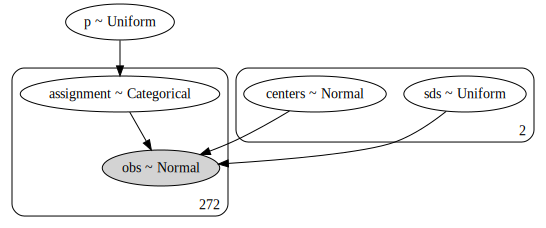

In [65]:
pm.model_to_graphviz(ofmodel)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


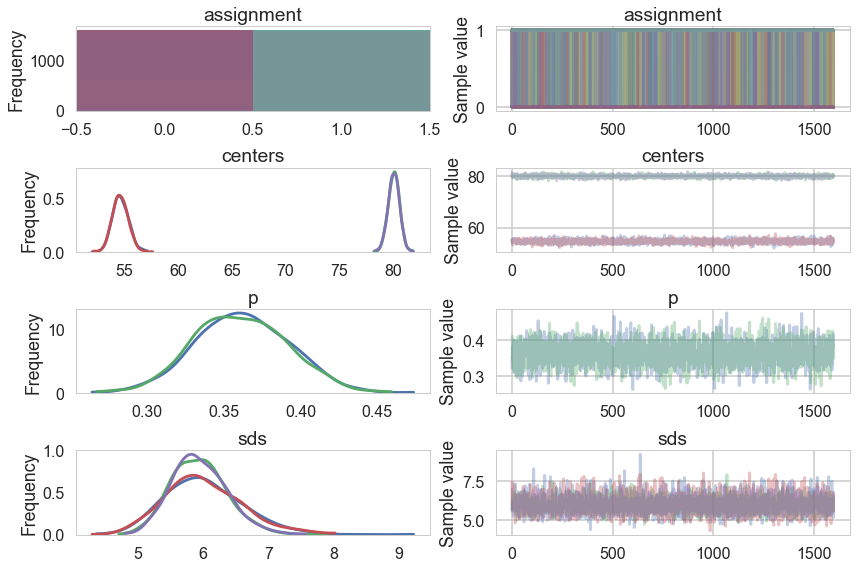

In [7]:
oftrace = oftrace_full[2000::5]
pm.traceplot(oftrace);

In [9]:
pm.summary(oftrace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
assignment__0,0.999687,0.017675,0.000311,1.000000,1.000000,NaN,1.000000
assignment__1,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
assignment__2,0.993125,0.082630,0.001504,1.000000,1.000000,3248.753445,0.999745
assignment__3,0.050937,0.219870,0.004231,0.000000,1.000000,3173.388070,1.000029
assignment__4,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN
assignment__5,0.000313,0.017675,0.000311,0.000000,0.000000,NaN,1.000000
assignment__6,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN
assignment__7,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN
assignment__8,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
assignment__9,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN


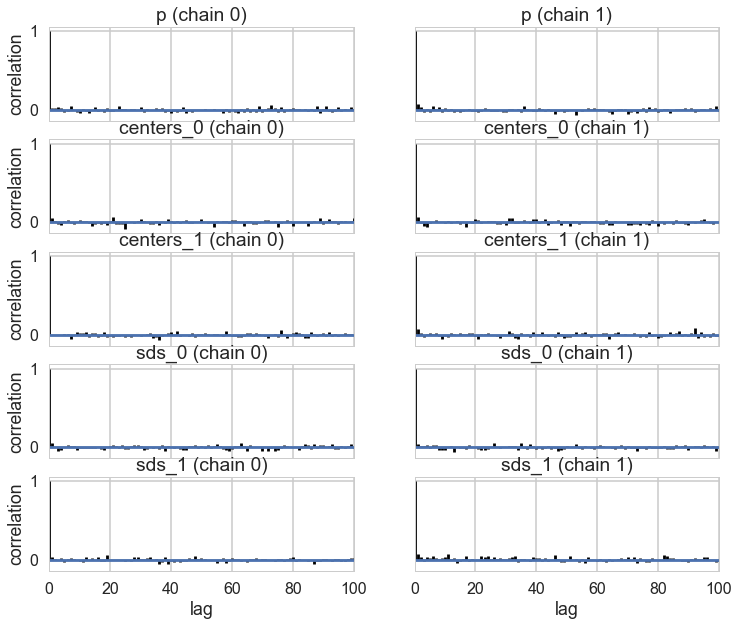

In [10]:
pm.autocorrplot(oftrace, varnames=['p', 'centers', 'sds']);

In [11]:
oftrace['centers'].mean(axis=0)

array([54.62752749, 80.0878344 ])

We can visualize the two clusters, suitably scales by the category-belonging probability by taking the posterior means. Note that this misses any smearing that might go into making the posterior predictive

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


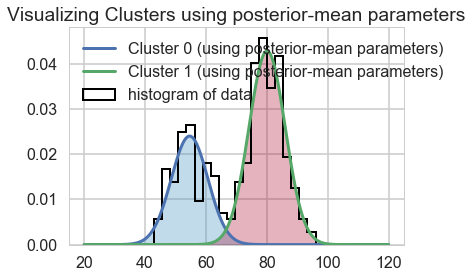

In [12]:
from scipy.stats import norm
x = np.linspace(20, 120, 500)
# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if oftrace['centers'][-1, 0] > oftrace['centers'][-1, 1] \
    else ["#A60628", "#348ABD"]

posterior_center_means = oftrace['centers'].mean(axis=0)
posterior_std_means = oftrace['sds'].mean(axis=0)
posterior_p_mean = oftrace["p"].mean()

plt.hist(ofdata.waiting, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

## A tetchy 3 Gaussian Model

Let us set up our data. Our analysis here follows that of https://colindcarroll.com/2018/07/20/why-im-excited-about-pymc3-v3.5.0/ , and we have chosen 3 gaussians reasonably close to each other to show the problems that arise!

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


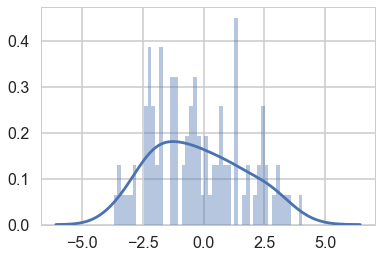

In [14]:
mu_true = np.array([-2, 0, 2])
sigma_true = np.array([1, 1, 1])
lambda_true = np.array([1/3, 1/3, 1/3])
n = 100
from scipy.stats import multinomial
# Simulate from each distribution according to mixing proportion psi
z = multinomial.rvs(1, lambda_true, size=n)
data=np.array([np.random.normal(mu_true[i.astype('bool')][0], sigma_true[i.astype('bool')][0]) for i in z])
sns.distplot(data, bins=50);

In [15]:
np.savetxt("data/3gv2.dat", data)

In [24]:
with pm.Model() as mof:
    #p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)
    p=[1/3, 1/3, 1/3]

    # cluster centers
    means = pm.Normal('means', mu=0, sd=10, shape=3)


    #sds = pm.HalfCauchy('sds', 5, shape=3)
    sds = np.array([1., 1., 1.])
    
    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=1., #sds[category],
                       observed=data)


In [25]:
with mof:
    tripletrace_full = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [means]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:39<00:00, 210.02draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


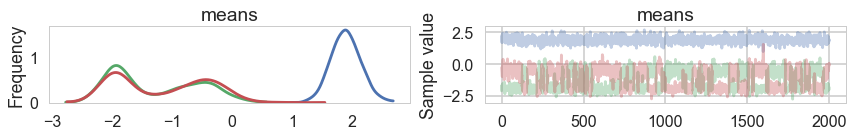

In [28]:
trace_mof=tripletrace_full[3000::7]
#pm.traceplot(trace_mof, varnames=["means", "p", "sds"]);
pm.traceplot(trace_mof, varnames=["means"], combined=True);

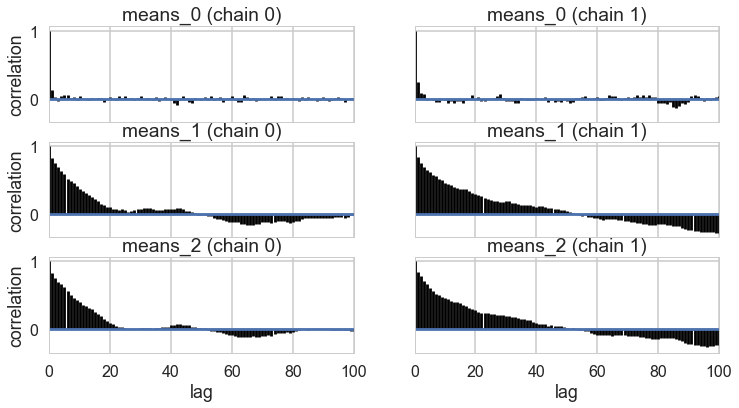

In [30]:
pm.autocorrplot(trace_mof, varnames=['means']);

## Problems with clusters and sampling

Some of the traces seem ok, but the autocorrelation is quite bad. And there is label-switching .This is because there are major problems with using MCMC for clustering.

AND THIS IS WITHOUT MODELING $p$ OR $\sigma$. It gets much worse otherwise! (it would be better if the gaussians were quite widely separated out).

These are firstly, the lack of parameter identifiability (the so called label-switching problem) and secondly, the multimodality of the posteriors.

We have seen non-identifiability before. Switching labels on the means and z's, for example, does not change the likelihoods. The problem with this is that cluster parameters cannot be compared across chains: what might be a cluster parameter in one chain could well belong to the other cluster in the second chain. Even within a single chain, indices might swap leading to a telltale back and forth in the traces for long chains or data not cleanly separated.

Also, the (joint) posteriors can be highly multimodal. One form of multimodality is the non-identifiability, though even without identifiability issues the posteriors are highly multimodal.

To quote the Stan manual:
>Bayesian inference fails in cases of high multimodality because there is no way to visit all of the modes in the posterior in appropriate proportions and thus no way to evaluate integrals involved in posterior predictive inference.
In light of these two problems, the advice often given in fitting clustering models is to try many different initializations and select the sample with the highest overall probability. It is also popular to use optimization-based point estimators such as expectation maximization or variational Bayes, which can be much more efficient than sampling-based approaches.

### Some mitigation via ordering in pymc3

But this is not a panacea. Sampling is still very hard.


In [45]:
import theano.tensor as tt
import pymc3.distributions.transforms as tr


with pm.Model() as mof2:
    
    p = [1/3, 1/3, 1/3]

    # cluster centers
    means = pm.Normal('means', mu=0, sd=10, shape=3,
                  transform=tr.ordered,
                  testval=np.array([-1, 0, 1]))


                                         
    # measurement error
    #sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=1., #sds[category],
                       observed=data)


In [46]:
with mof2:
    tripletrace_full2 = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [means]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 21000/21000 [03:42<00:00, 94.44draws/s] 
The acceptance probability does not match the target. It is 0.9255675538672136, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


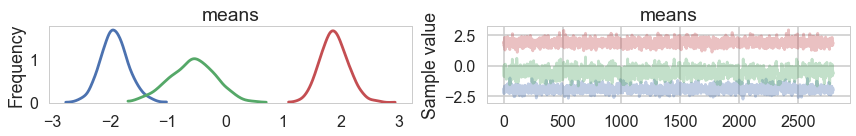

In [52]:
trace_mof2 = tripletrace_full2[3000::5]
pm.traceplot(trace_mof2, varnames=["means"], combined=True);

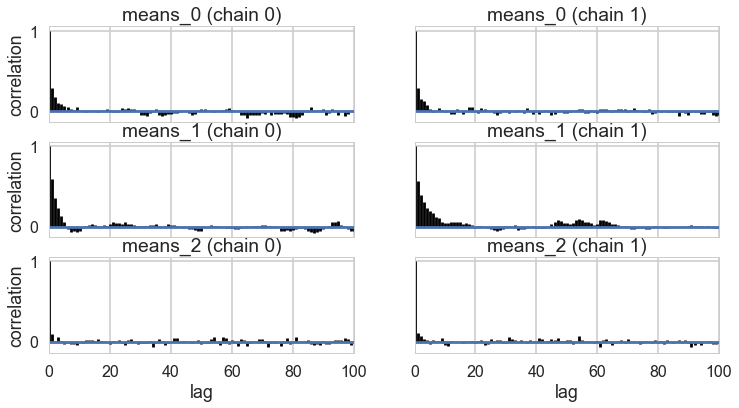

In [53]:
pm.autocorrplot(trace_mof2, varnames=["means"]);

## Full sampling is horrible, even with potentials

Now lets put Dirichlet based (and this is a strongly centering Dirichlet) prior on the probabilities

In [62]:
from scipy.stats import dirichlet
ds = dirichlet(alpha=[10,10,10]).rvs(1000)

In [63]:
"""
Visualize points on the 3-simplex (eg, the parameters of a
3-dimensional multinomial distributions) as a scatter plot 
contained within a 2D triangle.
David Andrzejewski (david.andrzej@gmail.com)
"""
import numpy as NP
import matplotlib.pyplot as P
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA

def plotSimplex(points, fig=None, 
                vertexlabels=['1','2','3'],
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    if(fig == None):        
        fig = P.figure()
    # Draw the triangle
    l1 = L.Line2D([0, 0.5, 1.0, 0], # xcoords
                  [0, NP.sqrt(3) / 2, 0, 0], # ycoords
                  color='k')
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    # Draw vertex labels
    fig.gca().text(-0.05, -0.05, vertexlabels[0])
    fig.gca().text(1.05, -0.05, vertexlabels[1])
    fig.gca().text(0.5, NP.sqrt(3) / 2 + 0.05, vertexlabels[2])
    # Project and draw the actual points
    projected = projectSimplex(points)
    P.scatter(projected[:,0], projected[:,1], **kwargs)              
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)

    return fig    

def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = NP.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * NP.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / NP.sqrt(3)) * p1 * NP.cos(NP.pi / 6)
        y = y - (1.0 / NP.sqrt(3)) * p1 * NP.sin(NP.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / NP.sqrt(3)) * p2 * NP.cos(NP.pi / 6)
        y = y - (1.0 / NP.sqrt(3)) * p2 * NP.sin(NP.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / NP.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts



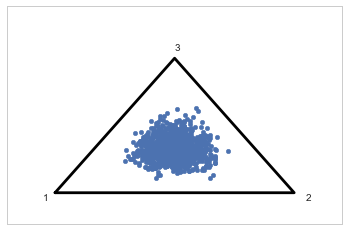

In [64]:
plotSimplex(ds, s=20);

The idea behind a `Potential` is something that is not part of the likelihood, but enforces a constraint by setting the probability to 0 if the constraint is violated. We use it here to give each cluster some membership and to order the means to remove the non-identifiability problem. See below for how its used.

The sampler below has a lot of problems. 

In [56]:
with pm.Model() as mofb:
    p = pm.Dirichlet('p', a=np.array([10., 10., 10.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    # cluster centers
    means = pm.Normal('means', mu=0, sd=10, shape=3, transform=tr.ordered,
                  testval=np.array([-1, 0, 1]))

    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=1., #sds[category],
                       observed=data)



In [59]:
with mofb:
    tripletrace_fullb = pm.sample(10000, nuts_kwargs=dict(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [means, p]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 21000/21000 [06:13<00:00, 56.23draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


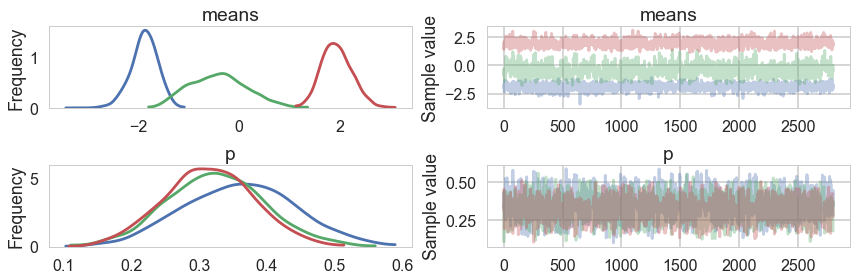

In [60]:
trace_mofb = tripletrace_fullb[3000::5]
pm.traceplot(trace_mofb, varnames=["means", "p"], combined=True);

In [61]:
pm.summary(trace_mofb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
category__0,1.406071,0.575480,0.014954,1.000000,2.000000,1362.583316,1.000115
category__1,0.228571,0.421610,0.010938,0.000000,1.000000,1306.422985,1.000472
category__2,0.395357,0.496897,0.011826,0.000000,1.000000,1674.615993,1.000276
category__3,0.108929,0.311550,0.008695,0.000000,1.000000,1307.190266,1.001074
category__4,0.824643,0.552559,0.011552,0.000000,2.000000,2328.351050,0.999864
category__5,0.280714,0.452516,0.011192,0.000000,1.000000,1662.033357,1.000363
category__6,1.948929,0.221760,0.004981,1.000000,2.000000,1702.198664,1.002138
category__7,1.712143,0.473583,0.012564,1.000000,2.000000,1256.089935,0.999754
category__8,0.900357,0.569837,0.011499,0.000000,2.000000,2245.021084,0.999675
category__9,1.739286,0.454218,0.012043,1.000000,2.000000,1421.562668,1.000357


### Making Problems go away

A lot will go away when identifiability improves through separated gaussians. But that changes the data. If we want any further improvement on this data, we are going to have to stop sampling so many discrete categoricals. And for that we will need a marginalization trick.